## Name: YenHsin Fang
## Section: 01

# Lab 9: Feature Importance

In this lab we will go through some simple ways of doing feature importance using either the built-in methods or through permutation. 

## Tools

#### Libraries:

- numpy: for processing
- sklearn: for model training and feature importances
- pandas: for data processing  

#### Datasets:

Boston housing 

## Setup

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance

from types import SimpleNamespace
def load_boston(return_X_y=False):
    """Replacement function for loading in Boston House Prices"""
    df = pd.read_csv('./data/boston_house_prices.csv')
    X = df.drop(columns=['MEDV'])
    y = df['MEDV'].to_numpy()

    if return_X_y:
        return X, y 
    
    dataset  = SimpleNamespace(data=X, target=y)
    
    return dataset

In [21]:
def boston():
    boston = load_boston()
    df = boston.data
    y = boston.target
    df['y'] = y
    return df

df_boston = boston()
X, y = df_boston.drop('y', axis=1), df_boston['y']
y *= 1000
X.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  
0  396.90   4.98  
1  396.90   9.14  
2  392.83   4.03  
3  394.63   2.94  
4  396.90   5.33

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Linear Models

First let's train a Lasso regression model and visualize the size of the coefficients to get something that looks like a standard feature importance bar chart.

In [6]:
# first let's rescale our data
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(X_train)

lmbda = .1

lm = Lasso(alpha=lmbda, tol=.1)
lm.fit(x_train_sc, y_train)

# extract the coefficients
importance = abs(lm.coef_)

importance

/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in 

array([ 987.31597096,  866.28147376,  403.84054093,  862.17796801,
       1898.79466096, 2808.99594299,  359.32850932, 3044.0570321 ,
       2026.56212439, 1358.87610007, 2082.07762449, 1041.1253087 ,
       3925.79685013])

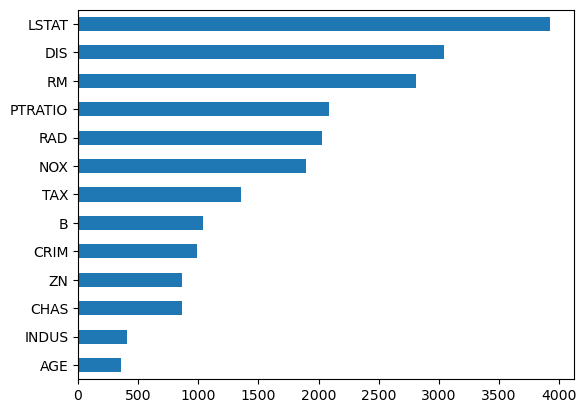

In [7]:
feat_importances = pd.Series(importance, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

We see in the plot above that LSTAT, RM, and DIS had the largest coefficients. For a regularized model, where the features have been normalized, the size of the coefficients can be an indicator of feature importance. We will see how much these agree with our other feature importance metrics below.

---
## Decision Tree

Now let's fit a simple decision tree and take a look at the feature importances it produces. To see which method it is using for importances you can look [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.feature_importances_).

In [8]:
tr_model = DecisionTreeRegressor()
tr_model.fit(X_train, y_train)

# extract feature importances and sort
importance = tr_model.feature_importances_

/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

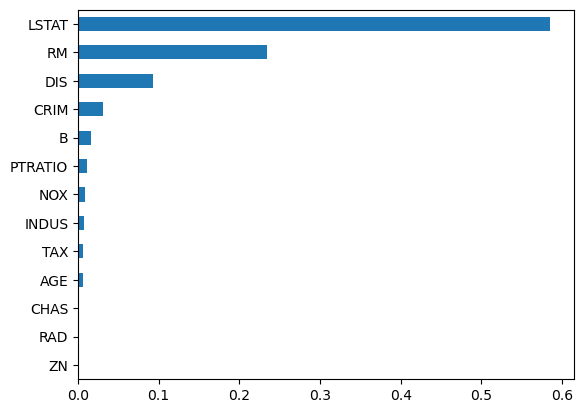

In [9]:
feat_importances = pd.Series(importance, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

---
**Q.** What were the most important features from the decision tree, and which method was used to create those feature importances?

The most importance features are LSTAT, RM and DIS. The method it used is to normalize total reduction of criteria by feature (Gini importance)

## Permutation Importance

We can specifically create feature importances using the permutation importance method by using `permutation_importance` from sklearn.

In [11]:
p_importance = permutation_importance(tr_model, X_train, y_train, n_repeats=25, random_state=12)

p_importances = p_importance.importances_mean

/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

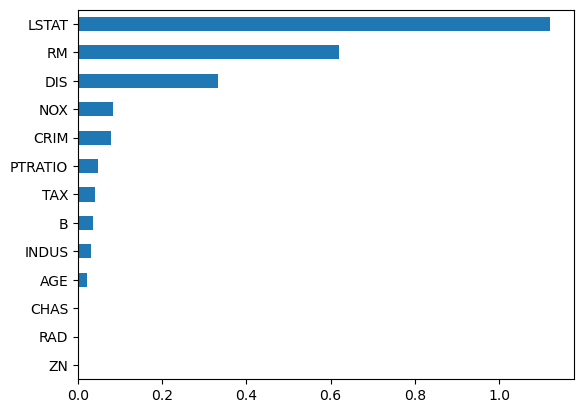

In [12]:
feat_importances = pd.Series(p_importances, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

---

**Q.** What have you noticed about the important features using each of the different methods above?

Permutation importance is caculated by permuting the values of each feature and measuring the impact on model performance (accuracy). And what I've noticed is that the order of top 3 important features has changed

---
## Random Forest

When we run the random forest we get a gini-based set of feature importances, so if we want permutation-based importances we have to specifically use the `permutation_importance()` function.

In [13]:
rf = RandomForestRegressor(n_estimators=30)
rf.fit(X_train, y_train)

p_importance = permutation_importance(rf, X_train, y_train, n_repeats=25, random_state=12)

/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

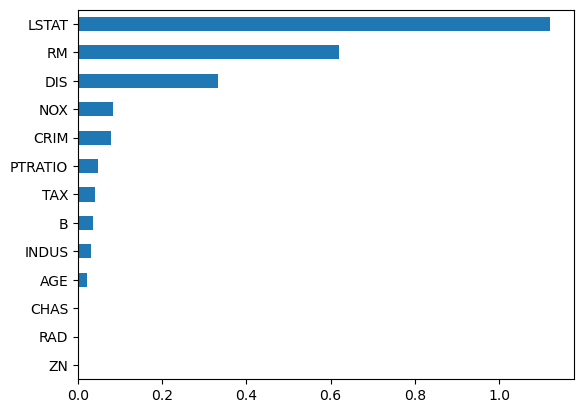

In [14]:
feat_importances = pd.Series(p_importances, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

Again, we are seeing a lot of agreement between our methods and models, which is nice. Below, just for completeness, let's extract the gini-based feature importances and take a look at them.

In [15]:
rf.feature_importances_

array([0.04524103, 0.0010618 , 0.00821981, 0.00187029, 0.0150962 ,
       0.35916421, 0.01474229, 0.06451581, 0.00702848, 0.00769172,
       0.01741746, 0.01159059, 0.44636032])

In [16]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

---
## Noise Column

Let's make sure these methods are actually working by adding a single column of noise to our training data and checking the importances. 

In [17]:
X_train['noise'] = np.random.uniform(size = len(X_train))

tr_model = DecisionTreeRegressor()
tr_model.fit(X_train, y_train)

p_importance = permutation_importance(tr_model, X_train, y_train, n_repeats=25, random_state=12)
p_importances = p_importance.importances_mean

/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

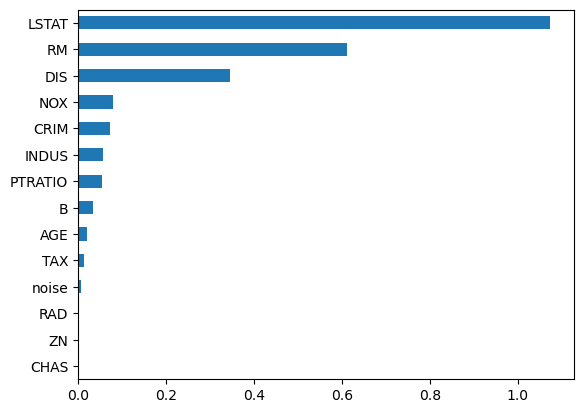

In [18]:
feat_importances = pd.Series(p_importances, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh').invert_yaxis()

Hopefully you see the noise feature somewhere near the bottom of the list. If we were to rerun it over and over again, we should see the noise feature bounce around a little, but near the bottom. 

**Q.** Explain why the noise feature is near the bottom of the list. Don't just say "because it's not important". Explain the mechanism behind why it gets such a low importance score.

I think that is because when we do the permutation to see the model performace, the decrease of accuary doesn't change much because of the randomess of the noise feature, and thus it is near the bottom of the list.

---
**Q.** Write a loop to train the random forest, calculate the permutation importances, and plot the bar chart 5 times and comment below and what you notice.

The order of top 3 important features changes (between LSTAT and RM) in each round.

/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

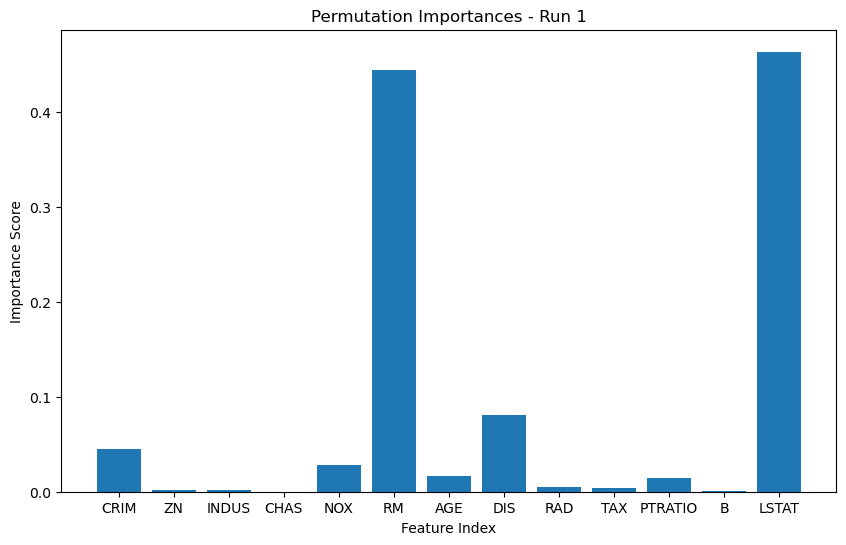

/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

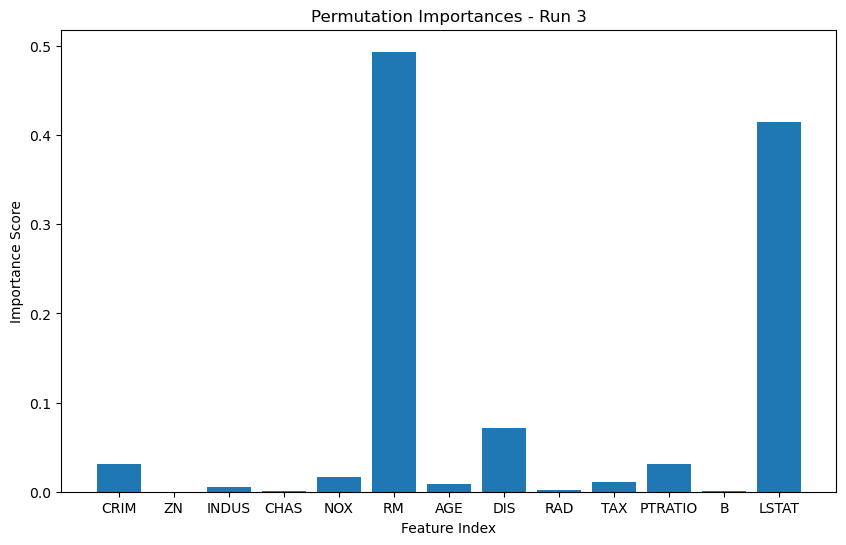

/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

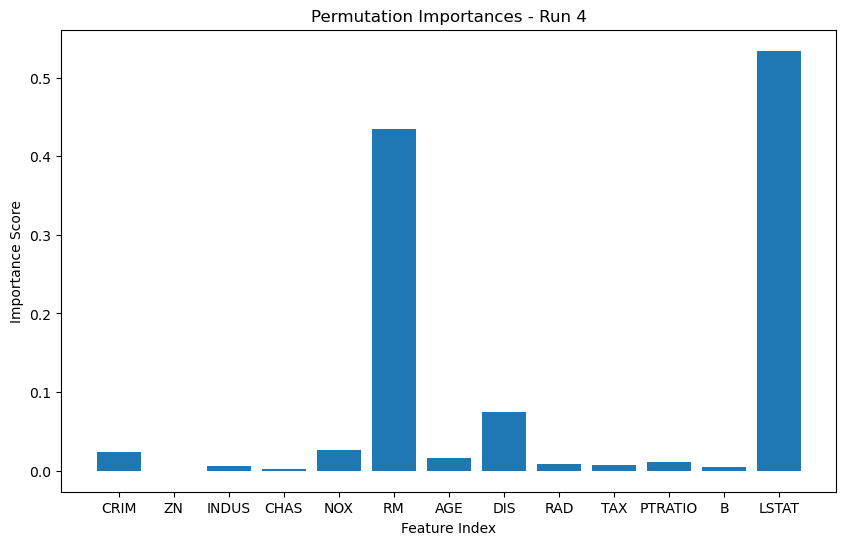

/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

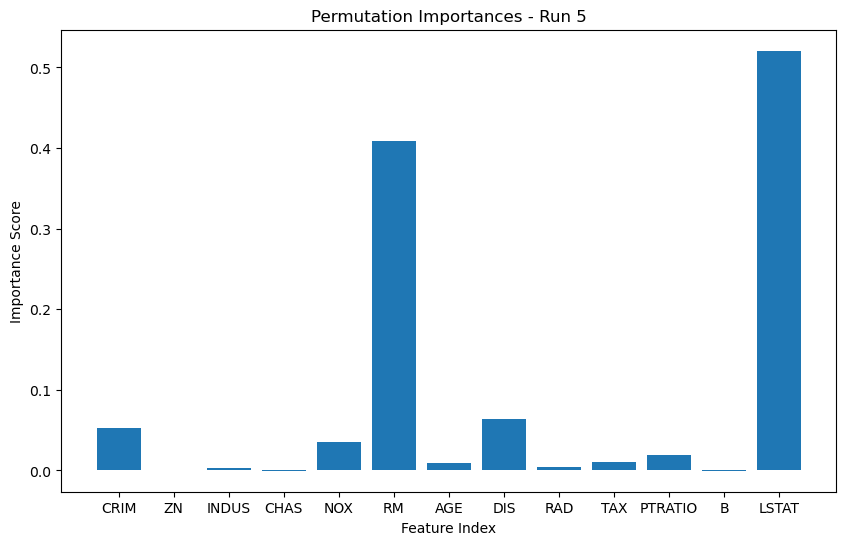

In [35]:
import matplotlib.pyplot as plt

for i in range(5):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit a random forest classifier
    rf_classifier = RandomForestRegressor(n_estimators=30)

    rf_classifier.fit(X_train, y_train)

    # Calculate permutation importances
    result = permutation_importance(rf_classifier, X_test, y_test, n_repeats=25, random_state=12)

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(X.columns.values, result.importances_mean)
    plt.title(f'Permutation Importances - Run {i+1}')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance Score')
    plt.show()